In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
STOCKS = ["MSFT", "GOOGL", "AMZN", "NVDA", "TSLA"]
stock_data = yf.download(STOCKS, start='2020-01-01', end='2023-10-01')
prices = stock_data["Close"]

[*********************100%***********************]  5 of 5 completed


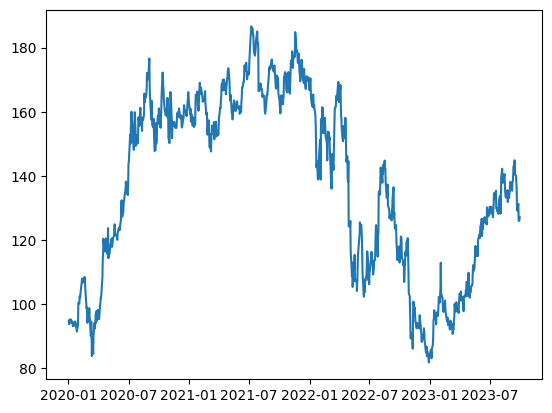

In [4]:
plt.plot(prices["AMZN"])
plt.show()

In [5]:
means = {ticker: prices[ticker].pct_change().mean() + 1 for ticker in STOCKS}
stds = {ticker: prices[ticker].pct_change().std() for ticker in STOCKS}
dt = 1
n = 1000
new_prices = {ticker + str(i): [] for i in range(n) for ticker in STOCKS}
indicies = []
prev_index = prices.index[-1]
prev_prices = {ticker + str(i): prices[ticker].iloc[-1] for i in range(n) for ticker in STOCKS}
for t in range(1000):  # 1000 days ahead
    for i in range(n):  # 2 predictions
        for ticker in STOCKS:  # for every chosen stock
            current_price = prev_prices[ticker + str(i)]
            predicted_return = means[ticker] * dt + stds[ticker] * np.random.normal() * np.sqrt(dt)
            new_price = current_price * predicted_return
            new_prices[ticker + str(i)].append(new_price)
            prev_prices[ticker + str(i)] = new_price
    new_index = prev_index + pd.Timedelta(days=dt)
    prev_index = new_index
    indicies.append(new_index)
new_prices = pd.DataFrame(new_prices, index=indicies)
print(new_prices)

                                MSFT0      GOOGL0       AMZN0        NVDA0  \
2023-09-30 00:00:00+00:00  312.414247  131.365927  122.461812    43.517147   
2023-10-01 00:00:00+00:00  313.446606  132.488575  123.401655    42.766620   
2023-10-02 00:00:00+00:00  308.651710  132.627280  128.967270    44.435646   
2023-10-03 00:00:00+00:00  316.202675  132.204983  134.435595    48.659497   
2023-10-04 00:00:00+00:00  318.242582  129.503788  132.742885    47.730127   
...                               ...         ...         ...          ...   
2026-06-21 00:00:00+00:00  430.100803  136.822156   97.283332  1260.978680   
2026-06-22 00:00:00+00:00  421.430519  139.570573  101.478524  1274.502853   
2026-06-23 00:00:00+00:00  425.386818  138.461421   97.439830  1224.223809   
2026-06-24 00:00:00+00:00  430.019804  132.413284   97.752012  1219.404291   
2026-06-25 00:00:00+00:00  422.221012  134.239445   98.708941  1247.145185   

                                 TSLA0       MSFT1      GOOGL1 

C:\Users\aatus\AppData\Local\Temp\ipykernel_15368\267284668.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  distribution.append(new_prices[f"{ticker}{i}"][-1])


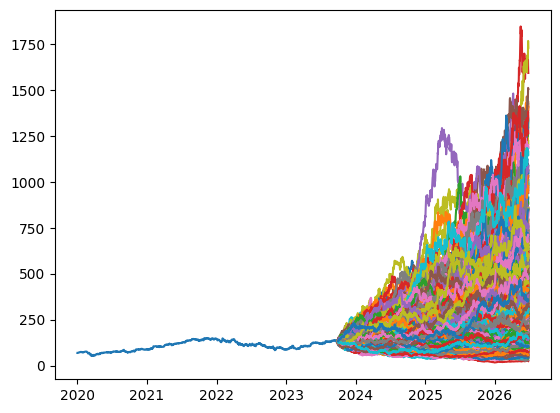

In [6]:
ticker = "GOOGL"

plt.plot(prices[ticker])
distribution = []
for i in range(n):
    plt.plot(new_prices[f"{ticker}{i}"])
    distribution.append(new_prices[f"{ticker}{i}"][-1])
plt.show()


In [7]:
counts, bins = np.histogram(distribution, bins=np.logspace(np.log(1e-3), np.log(45), 100), density=True)
x = (bins[1:] - bins[:-1]) / 2
y = counts

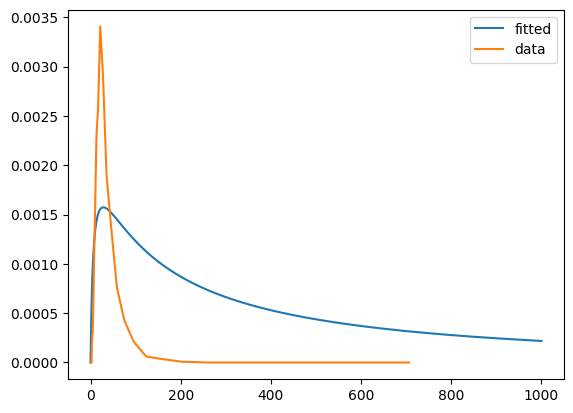

In [8]:
from scipy.optimize import curve_fit

def log_normal(x, sigma, mu):
    const = 1 / (x * sigma * np.sqrt(2 * np.pi))
    exponential = np.exp(-((np.log(x) - mu) ** 2) / (2 * sigma ** 2))
    return const * exponential

popt, pcov = curve_fit(log_normal, x, y)
x_test = np.linspace(1e-3, 1000, 1000)
y_test = log_normal(x_test, *popt)
plt.plot(x_test, y_test, label="fitted")
plt.plot(x, y, label="data")
plt.legend()
plt.show()

85.2
664.1754511201614


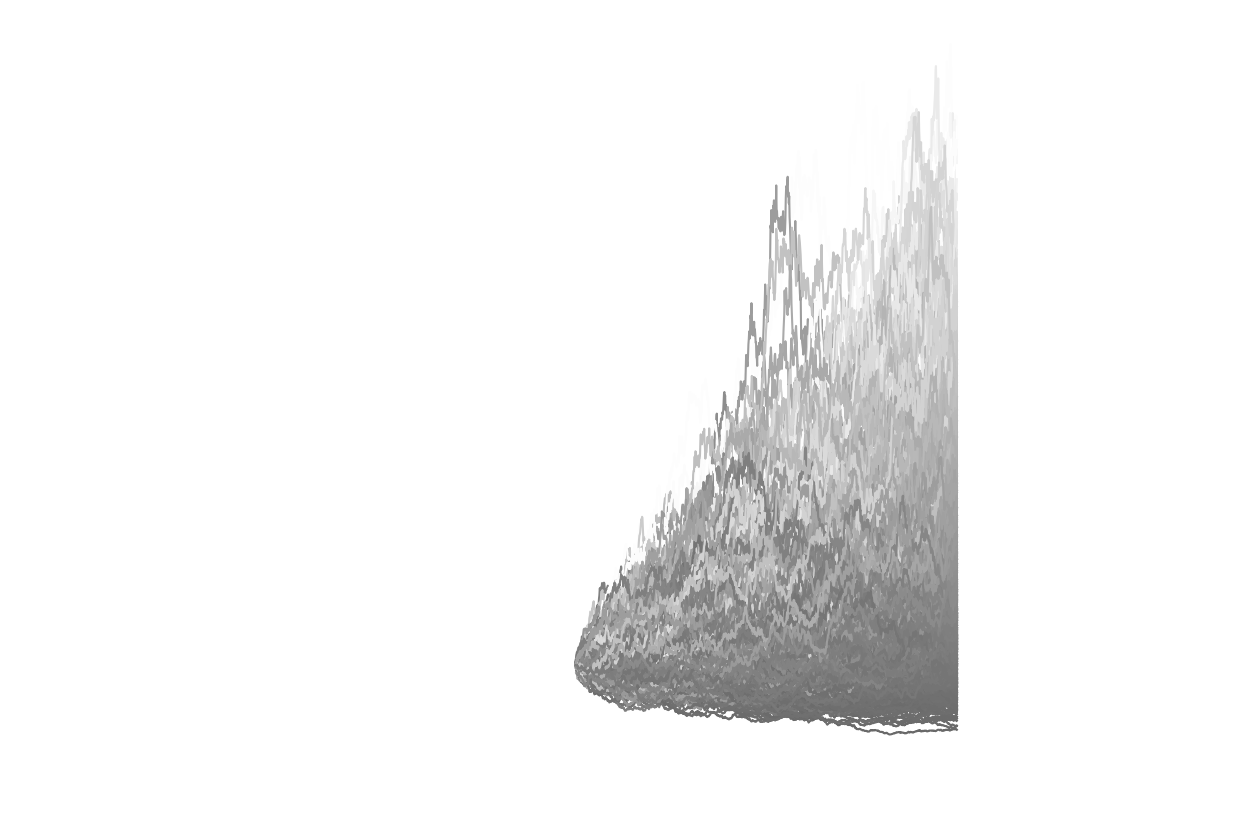

In [11]:
import matplotlib.colors as mcolors

fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(1, 2, width_ratios=[4, 1], wspace=0)

ax_main = fig.add_subplot(gs[0])
ax_side = fig.add_subplot(gs[1], sharey=ax_main)

last_values = np.array([new_prices[f"{ticker}{i}"].iloc[-1] for i in range(n) if new_prices[f"{ticker}{i}"].iloc[-1] < 1000])
norm = mcolors.Normalize(vmin=last_values.min(), vmax=last_values.max())
# cmap = plt.cm.get_cmap('RdYlGn')
cmap = mcolors.LinearSegmentedColormap.from_list("gray_white", ["dimgray", "white"])

ticker = "GOOGL"
ax_main.plot(prices[ticker], color="white")

initial_price = prices[ticker].iloc[0]
before_prediction_price = prices[ticker].iloc[-1]
positive_return = 0
negative_return = 0
for i in range(n):
    last_value = new_prices[f"{ticker}{i}"].iloc[-1]
    if last_value < before_prediction_price:
        negative_return += 1
    else:
        positive_return += 1
    if last_value < 1000:
        color = cmap(norm(last_value))
        ax_main.plot(new_prices[f"{ticker}{i}"], color=color)
print(100 * positive_return / (negative_return + positive_return))
print(100 * (1000 - before_prediction_price) / before_prediction_price)

ax_side.plot(y_test[1:], x_test[1:], color="white")

# mean = y_test.mean()
# cdf = np.cumsum(y_test)
# cdf /= cdf[-1]
# lower_bound_index = np.searchsorted(cdf, 0.25)
# upper_bound_index = np.searchsorted(cdf, 0.75)
# ax_side.fill_betweenx(x_test[lower_bound_index:upper_bound_index], 0, y_test[lower_bound_index:upper_bound_index], color='white', alpha=0.5)
ax_side.fill_betweenx(x_test[before_prediction_price <= x_test], 0.0002, y_test[before_prediction_price <= x_test], color='white', alpha=0.5)

fig.patch.set_alpha(0)
ax_main.patch.set_alpha(0)
ax_side.patch.set_alpha(0)

ax_main.tick_params(axis='x', colors='white')
ax_main.xaxis.label.set_color('white')
ax_main.spines['bottom'].set_color('white')
ax_main.tick_params(axis='y', colors='white', left=False, labelleft=False)
ax_main.yaxis.label.set_color('white')
ax_main.spines['right'].set_color('white')

ax_main.spines['top'].set_visible(False)
# ax_main.spines['right'].set_visible(False)
ax_main.spines['left'].set_visible(False)
# ax_main.spines['bottom'].set_visible(False)
# ax_main.xaxis.set_ticks([])
ax_main.yaxis.set_ticks([0, before_prediction_price, 2.0 * before_prediction_price, 1000])
ax_main.set_yticklabels(("", "", "", ""))
# ax_main.set_yticklabels(("-100%", f"{round(100 * (1000 - initial_price) / initial_price)}%"))

ax_side.tick_params(axis='y', colors='white')
ax_side.spines['top'].set_visible(False)
ax_side.spines['right'].set_visible(False)
ax_side.spines['left'].set_visible(False)
ax_side.spines['bottom'].set_visible(False)
ax_side.xaxis.set_ticks([])
# ax_side.yaxis.set_ticks([])
plt.savefig('transparent_plot.png', dpi=500, transparent=True, bbox_inches='tight', pad_inches=0)
plt.show()